# Demonstrational notebook: fitting neural networks to time to event data with stratified loss functions

In this notebook, you can explore the functionality of the provided software for fitting neural networks to time to event data using stratified loss functions and to subsequently evaluate the networks in terms of the c-index or prediction error. In contrast to the data shown in the manuscript, the expression data is pruned to 500 features (genes) and only a single network architecture is evaluated. For reproducing the analysis shown in the manuscript, please use the "train_models.py" file. Subsequently, evaluation can be carried out with the "evaluate_models.py" file where paths can be adjusted to fit the needs. 

## Load the required packages

In [1]:
# Import modules.
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import collections
import os
import shap
import matplotlib.pyplot as plt

from src.modules.evaluation_metrics import stratified_concordance_index, stratified_brier_score
from src.modules.torch_models import BaseFeedForwardNet, StratifiedPartialLikelihoodLoss, StratifiedRankingLoss

## Set Hyperparameters

### Related to network

In [2]:
LEARNING_RATE = 0.0001
MAX_EPOCHS = 200 # maximum number of training epochs, training is usually interrupted by an early stopping criterion
HIDDEN_LAYERS = [200,100,50,25] # Here we have 4 hidden layers.

### Related to estimation

In [3]:
CV_FOLDS = 5 # Number of folds investigated in cross validation
kf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=42) # initialization of random number generator for assigining patients to test and training set.

loss_functions = {
    "Partial Likelihood": StratifiedPartialLikelihoodLoss,
    "Stratified Partial Likelihood": StratifiedPartialLikelihoodLoss,
    "Ranking Loss": StratifiedRankingLoss,
    "Stratified Ranking Loss": StratifiedRankingLoss
} # The loss functions investigated.

### Related to evaluation

In [4]:
BRIER_EVAL_TIME = 1500 # End of the investigated time period for which the brier score is computed 
EVALUATION_TIMES_PEC = list(range(10, BRIER_EVAL_TIME, 30)) # Evaluation points in time for prediction error curves.

SHAP_BACKGROUND_SIZE = 200 #  Number of observations used as background in SHAP.

##  Data

### Set the path to the expression and clinical data

In [5]:
data_path = "./demo_data_500_features.csv" # change this according to your data 

### Load and inspect the data
'tumor_type' indicates the strata.

In [6]:
data = pd.read_csv(data_path)
data.head()

,Unnamed: 0,patient_id,tumor_type,time,event,A2M,ABAT,ABHD2,ABP1,ACTA2,...,VCAN,VEGFA,VIM,VTCN1,VWF,WFDC2,XBP1,YWHAE,YWHAZ,ZFP36
0,0,TCGA-E1-5318-01A-01R-1470-07,GLIOMA,2379,True,0.023346,3.142980,1.033013,-0.318530,-0.686469,...,0.118875,-0.382251,-0.859777,-0.242002,0.301206,-0.437977,-0.599295,1.943284,-0.598019,-0.687688
1,1,TCGA-A2-A0T1-01A-21R-A084-07,BRCA,323,False,-0.066054,-0.634124,-0.404104,-0.306989,-0.195976,...,0.411752,-0.400845,-0.094011,0.054934,-0.142607,-0.438043,0.087162,-1.099904,2.702812,-0.476179
2,2,TCGA-A7-A3J0-01A-11R-A213-07,BRCA,76,False,-0.551878,-0.465916,1.428998,-0.317776,-0.347184,...,-0.880078,-0.382416,-0.625069,-0.190240,-0.445837,-0.064468,3.752852,1.174263,0.393702,-0.387545
3,3,TCGA-AO-A126-01A-11R-A10J-07,BRCA,2850,False,-0.335146,-0.559927,-0.565609,-0.318008,2.475635,...,0.107983,-0.485504,0.149641,-0.179321,-0.333335,0.001020,0.780592,-0.238276,0.498810,-0.216534
4,4,TCGA-E2-A14X-01A-11R-A115-07,BRCA,692,False,0.144971,-0.622441,-0.216345,-0.313949,1.386158,...,-0.242785,-0.358692,-0.550377,1.442183,-0.210088,-0.325096,-0.011898,0.186934,4.879274,0.131548


### Extract expression data and end-points (labels)

In [7]:
data.index = data.patient_id
gene_counts = data.iloc[:, 5:]
gene_counts_dim = gene_counts.shape[1]
gene_names = gene_counts.columns
event_indicator = data.event.to_numpy(dtype=np.bool)
event_time = data.time.to_numpy(dtype=np.int16)
strata = data.tumor_type.to_numpy(dtype=np.str)
patient_id = data.patient_id.to_numpy()

## Initialization of structures for network training

In [8]:
# Empty placeholder for prediction error.
prediction_error_curves_PartialLikelihood = pd.DataFrame(columns=[str(t) for t in EVALUATION_TIMES_PEC])
prediction_error_curves_StratifiedPartialLikelihood = pd.DataFrame(columns=[str(t) for t in EVALUATION_TIMES_PEC])
prediction_error_curves_RankingLoss = pd.DataFrame(columns=[str(t) for t in EVALUATION_TIMES_PEC])
prediction_error_curves_StratifiedRankingLoss = pd.DataFrame(columns=[str(t) for t in EVALUATION_TIMES_PEC])

# Placeholder for concordance index scores.
concordance_index_summary_df = pd.DataFrame(columns=loss_functions.keys())


# Placeholder for Shap values.
shap_values_PartialLikelihood = pd.DataFrame(index=patient_id, columns=gene_names)
shap_values_StratifiedPartialLikelihood = pd.DataFrame(index=patient_id, columns=gene_names)
shap_values_RankingLoss = pd.DataFrame(index=patient_id, columns=gene_names)
shap_values_StratifiedRankingLoss = pd.DataFrame(index=patient_id, columns=gene_names)

def weights_init(m):
    try:
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
    except:
        pass

## Training and evaluation 
Here, given the data and hyperparameters set above, neural networks are trained on 'CV_FOLDS' folds using the loss functions specified in 'loss_functions'. During training, SHAP values are computed and models are evaluated in terms of the c-index and the prediction error (Brier Score) using test data, not employed for training. An early stopping criterion is employed and only the values of c-index and prediction error from the last training epoch are further considered. However, values can be printed for each epoch by setting the 'verbose' switch to 'True'.

In [9]:
split_no = 1
verbose = False
for train_idx, test_idx in kf.split(gene_counts, y=strata):
    # Data and PyTorch Tensor initialization.
    gene_counts_train = gene_counts.iloc[train_idx]
    gene_counts_test = gene_counts.iloc[test_idx]
    patient_id_train = gene_counts_train.index
    patient_id_test = gene_counts_test.index
    event_indicator_train = event_indicator[train_idx]
    event_indicator_test = event_indicator[test_idx]
    event_time_train = event_time[train_idx]
    event_time_test = event_time[test_idx]
    X_train = torch.tensor(gene_counts_train.to_numpy(), requires_grad=False, dtype=torch.float32)
    X_test = torch.tensor(gene_counts_test.to_numpy(), requires_grad=False, dtype=torch.float32)

    # Background samples for shap value estimation.
    shap_background = X_train[np.random.choice(X_train.size()[0], SHAP_BACKGROUND_SIZE, replace=False)]

    # Structured arrays for Brier Score Evaluation.
    survival_data_train = np.zeros(event_indicator_train.shape[0],
        dtype={'names':('event_indicator', 'event_time'), 'formats':('bool', 'u2')})
    survival_data_train['event_indicator'] = event_indicator_train
    survival_data_train['event_time'] = event_time_train
    survival_data_test = np.zeros(event_indicator_test.shape[0],
        dtype={'names':('event_indicator', 'event_time'), 'formats':('bool', 'u2')})
    survival_data_test['event_indicator'] = event_indicator_test
    survival_data_test['event_time'] = event_time_test

    # Initialize model with given loss_functions.
    current_concordance_index = []
    for loss_name, loss_function in loss_functions.items():           
        try:
            # Clean up if model exists.
            del net
        except:
            pass
        finally:
            net = BaseFeedForwardNet(gene_counts_dim, 1, hidden_dims=HIDDEN_LAYERS)
            optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
            net.apply(weights_init)
        print("\n\n")
        print("________________________________________________________________")
        print("Split/Total Splits: {}/{}".format(split_no, CV_FOLDS))
        print("Model             : {}".format(loss_name))
        print("Hidden Layers     : {}".format(HIDDEN_LAYERS))
        print("\n")
        loss_func = loss_function()

        # Monitor the last four brier scores.
        recent_brier_scores = collections.deque([1.0, 1.0, 1.0, 1.0])
        top_brier_score = 1.0

        # Stratificaion.
        if "Stratified" in loss_name:
            strata_train = strata[train_idx]
            strata_test = strata[test_idx]
        else:
            strata_train = np.full(len(event_indicator_train), "NOT STRATIFIED")
            strata_test = np.full(len(event_indicator_test), "NOT STRATIFIED")
        strata_test_c_index = strata[test_idx]

        # Start Training.
        for epoch in range(MAX_EPOCHS):
            # Training Phase.
            net.train()
            optimizer.zero_grad()
            output_train = net(X_train)
            loss = loss_func(output_train,
                            event_time_train,
                            event_indicator_train,
                            strata=strata_train)
            loss.backward()
            optimizer.step()

            # Evaluation Phase ___________________________________________
            net.eval()
            with torch.no_grad():
                numpy_output_train = torch.squeeze(output_train.detach(), dim=1).numpy()
                numpy_output_test = torch.squeeze(net(X_test).detach(), dim=1).numpy()
                new_brier_score = stratified_brier_score(BRIER_EVAL_TIME,
                                                         survival_data_train,
                                                         survival_data_test,
                                                         numpy_output_train,
                                                         numpy_output_test, 
                                                         strata_train=strata_train,
                                                         strata_test=strata_test)
                c_index = stratified_concordance_index(numpy_output_test, event_indicator_test, event_time_test, strata_test_c_index) 

            # Early stopping criterium.
            if (new_brier_score > recent_brier_scores[-1] and epoch > 10) or epoch == MAX_EPOCHS - 1:
                print("stopped at Epoch: {:3d}".format(epoch))
                e = shap.DeepExplainer(net, shap_background)
                shap_values = e.shap_values(X_test)
                prediction_error_curve = pd.Series(
                    [stratified_brier_score(t,
                                            survival_data_train,
                                            survival_data_test,
                                            numpy_output_train,
                                            numpy_output_test, 
                                            strata_train=strata_train,
                                            strata_test=strata_test
                                            )
                        for t in EVALUATION_TIMES_PEC
                    ], index=[str(t) for t in EVALUATION_TIMES_PEC])
                if loss_name == "Partial Likelihood":
                    prediction_error_curves_PartialLikelihood = \
                        prediction_error_curves_PartialLikelihood.append(prediction_error_curve, ignore_index=True)
                    
                    shap_values_PartialLikelihood.loc[patient_id_test] = shap_values
                elif loss_name == "Stratified Partial Likelihood":
                    prediction_error_curves_StratifiedPartialLikelihood = \
                        prediction_error_curves_StratifiedPartialLikelihood.append(prediction_error_curve, ignore_index=True)
                    shap_values_StratifiedPartialLikelihood.loc[patient_id_test] = shap_values
                elif loss_name == "Ranking Loss":
                    prediction_error_curves_RankingLoss = \
                        prediction_error_curves_RankingLoss.append(prediction_error_curve, ignore_index=True)
                    shap_values_RankingLoss.loc[patient_id_test] = shap_values
                elif loss_name == "Stratified Ranking Loss":
                    prediction_error_curves_StratifiedRankingLoss = \
                        prediction_error_curves_StratifiedRankingLoss.append(prediction_error_curve, ignore_index=True)
                    shap_values_StratifiedRankingLoss.loc[patient_id_test] = shap_values
                # Concordance Index
                current_concordance_index.append(c_index)
                break
            elif new_brier_score < top_brier_score:
                top_brier_score = new_brier_score
            recent_brier_scores.appendleft(new_brier_score)
            recent_brier_scores.pop()
            if verbose:
                print("Epoch: {:3d} | Loss: {:.2f} | C-Index: {:.4f} | Brier Score: {:.4f}".format(epoch, loss.item(), c_index, new_brier_score))
                
    concordance_index_summary_df = concordance_index_summary_df.append(pd.Series(current_concordance_index, index=loss_functions.keys()), ignore_index=True)
    split_no += 1




________________________________________________________________
Split/Total Splits: 1/5
Model             : Partial Likelihood
Hidden Layers     : [200, 100, 50, 25]


stopped at Epoch:  27



________________________________________________________________
Split/Total Splits: 1/5
Model             : Stratified Partial Likelihood
Hidden Layers     : [200, 100, 50, 25]


stopped at Epoch:  39



________________________________________________________________
Split/Total Splits: 1/5
Model             : Ranking Loss
Hidden Layers     : [200, 100, 50, 25]


stopped at Epoch:  29



________________________________________________________________
Split/Total Splits: 1/5
Model             : Stratified Ranking Loss
Hidden Layers     : [200, 100, 50, 25]


stopped at Epoch:  22



________________________________________________________________
Split/Total Splits: 2/5
Model             : Partial Likelihood
Hidden Layers     : [200, 100, 50, 25]


stopped at Epoch:  69



_________________

### C-index
Values are averages over all investigated folds.

In [10]:
# Concordance Index
print("\n\nMean C-Index:\n")
print(concordance_index_summary_df.mean())



Mean C-Index:

Partial Likelihood               0.708829
Stratified Partial Likelihood    0.715330
Ranking Loss                     0.699169
Stratified Ranking Loss          0.699633
dtype: float64


### Integrated prediction error / Brier score
Values, averaged over all investigated folds, are integrated over the investigated time ('BRIER_EVAL_TIME').

In [11]:
# Integrated mean Prediction Error Curves"
print("\n\nMean integrated prediction error curves:\n")

print("Partial Likelihood           : {}".format(
    np.trapz(y=prediction_error_curves_PartialLikelihood.mean(), x=EVALUATION_TIMES_PEC)))
print("Stratified Partial Likelihood: {}".format(
    np.trapz(y=prediction_error_curves_StratifiedPartialLikelihood.mean(), x=EVALUATION_TIMES_PEC)))
print("Ranking Loss                 : {}".format(
    np.trapz(y=prediction_error_curves_RankingLoss.mean(), x=EVALUATION_TIMES_PEC)))
print("Stratified Ranking Loss      : {}".format(
    np.trapz(y=prediction_error_curves_StratifiedRankingLoss.mean(), x=EVALUATION_TIMES_PEC)))



Mean integrated prediction error curves:

Partial Likelihood           : 134.0081564283112
Stratified Partial Likelihood: 129.78308349901818
Ranking Loss                 : 133.7005482635715
Stratified Ranking Loss      : 130.14805847636552


### Prediction error curves
Prediction error is plotted against observation time for each fold.

Text(0, 0.5, 'Prediction Error')

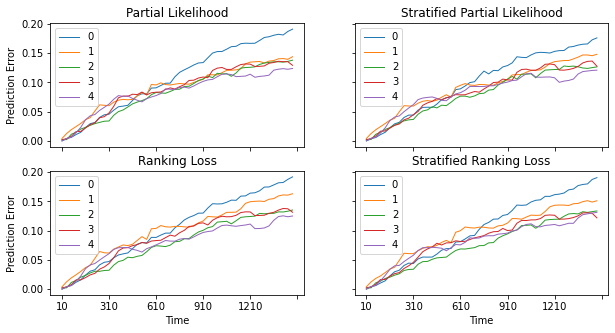

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10,5))
prediction_error_curves_PartialLikelihood.T.plot.line(ax=ax1,linewidth=1)
ax1.set_title("Partial Likelihood")
ax1.set_xlabel("Time")
ax1.set_ylabel("Prediction Error")

prediction_error_curves_StratifiedPartialLikelihood.T.plot.line(ax=ax2,linewidth=1)
ax2.set_title("Stratified Partial Likelihood")
ax2.set_xlabel("Time")
ax2.set_ylabel("Prediction Error")

prediction_error_curves_RankingLoss.T.plot.line(ax=ax3,linewidth=1)
ax3.set_title("Ranking Loss")
ax3.set_xlabel("Time")
ax3.set_ylabel("Prediction Error")

prediction_error_curves_StratifiedRankingLoss.T.plot.line(ax=ax4,linewidth=1)
ax4.set_title("Stratified Ranking Loss")
ax4.set_xlabel("Time")
ax4.set_ylabel("Prediction Error")


## SHAP evaluation for GLIOMA patients.
Here we plot SHAP values for GLIOMA patients and can for each individual patient observe, how much a given gene contributed to the prediction.


SHAP summary plot Partial Likelihood


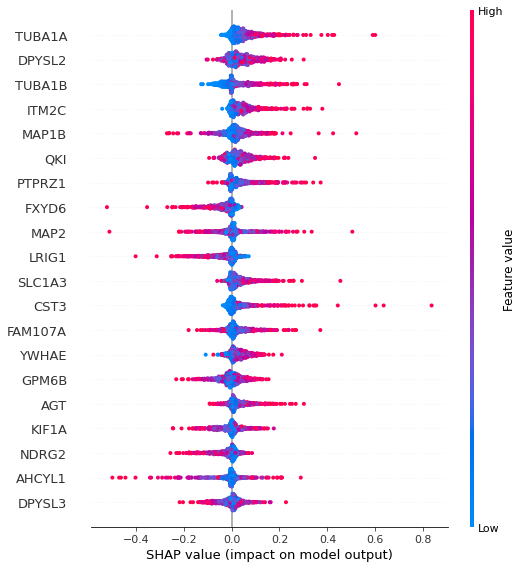


SHAP summary plot Stratified Partial Likelihood


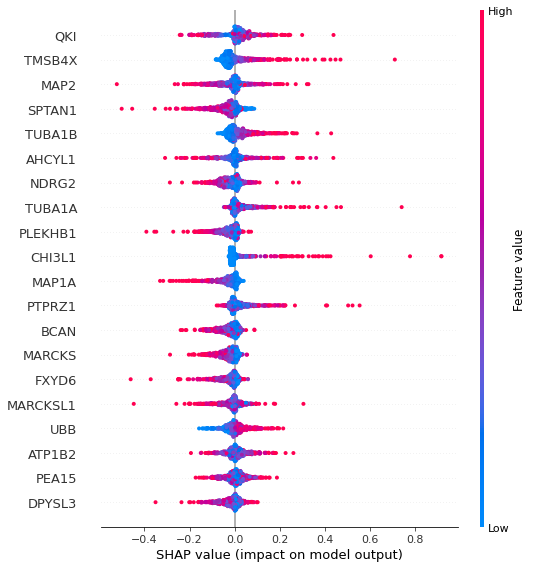


SHAP summary plot Ranking Loss


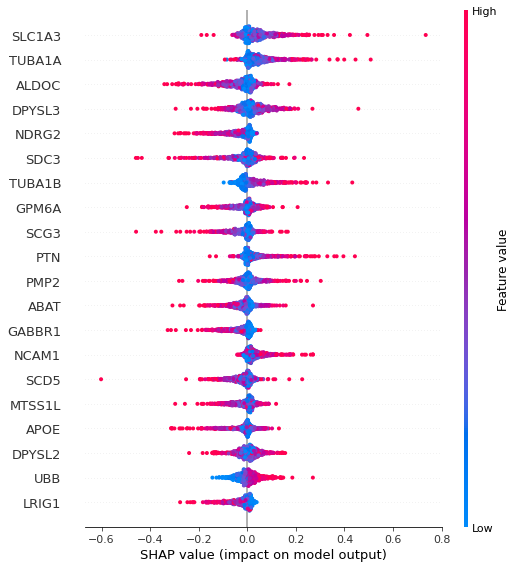


SHAP summary plot Stratified Ranking Loss


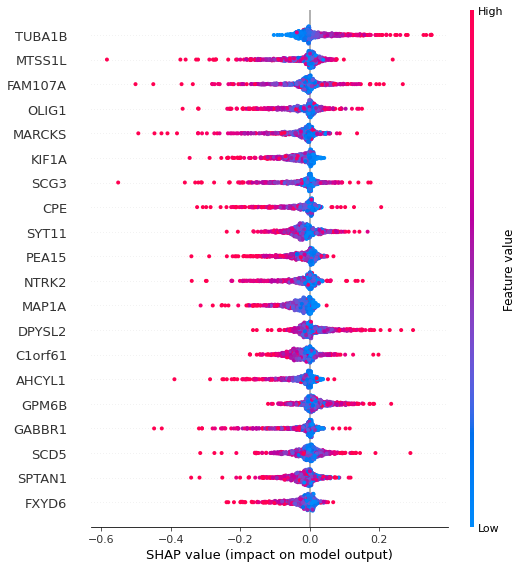

<Figure size 432x288 with 0 Axes>

In [13]:
glioma_patients = data.loc[data.tumor_type == "GLIOMA"].index

gene_counts_glioma = gene_counts.loc[glioma_patients].to_numpy()

shap_values_glioma_pl = shap_values_PartialLikelihood.astype('float64').loc[glioma_patients].to_numpy()
shap_values_glioma_spl = shap_values_StratifiedPartialLikelihood.astype('float64').loc[glioma_patients].to_numpy()
shap_values_glioma_rl = shap_values_RankingLoss.astype('float64').loc[glioma_patients].to_numpy()
shap_values_glioma_srl = shap_values_StratifiedRankingLoss.astype('float64').loc[glioma_patients].to_numpy()

print("\nSHAP summary plot Partial Likelihood")
shap.summary_plot(shap_values_glioma_pl, gene_counts_glioma, feature_names=gene_names, show=True)
plt.clf()

print("\nSHAP summary plot Stratified Partial Likelihood")
shap.summary_plot(shap_values_glioma_spl, gene_counts_glioma, feature_names=gene_names, show=True)
plt.clf()

print("\nSHAP summary plot Ranking Loss")
shap.summary_plot(shap_values_glioma_rl, gene_counts_glioma, feature_names=gene_names, show=True)
plt.clf()

print("\nSHAP summary plot Stratified Ranking Loss")
shap.summary_plot(shap_values_glioma_srl, gene_counts_glioma, feature_names=gene_names, show=True)
plt.clf()